# Features of genes associated with 2 monogenic disorders

# Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

import argparse
import subprocess
import maths
import csv

from pyhpo import HPOSet, Ontology
from pybedtools import BedTool
from itertools import zip_longest

In [2]:
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [3]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)
library(qqman)
library(hexbin)
library(RColorBrewer)
library(enrichplot)
library(clusterProfiler)
library(msigdbr)
library(gridExtra)
library(tidyverse)

R[write to console]: 
Присоединяю пакет: ‘dplyr’


R[write to console]: Следующие объекты скрыты от ‘package:stats’:

    filter, lag


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ tibble  3.2.1     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 1.0.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



# Load data and select genes linked to exactly 2 monogenic diseases

In [4]:
df_m = pd.read_csv('clinvar_grch38_plp_hpo_MIMcount.csv', sep='\t')
df_m.head(3)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AF_EXAC,CLNREVSTAT,CLNSIG,CLNVC,GENEINFO,OMIM,ORPHA,ncbi_gene_id,Inheritance,Ensembl,MIMs_per_Gene
0,chr1,1013983,1028857,G,A,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1
1,chr1,1014143,183381,C,T,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1
2,chr1,1014316,161455,C,CG,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,Duplication,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1


In [5]:
# Subset and count genes with 2 associated diseases

df_2dis = df_m[df_m['MIMs_per_Gene'] == 2]
print('N of genes associated with 2 diseases:',df_2dis['GENEINFO'].drop_duplicates().shape[0])

N of genes associated with 2 diseases: 670


## Distribution of inheritance patterns of 2 diseases linked to one gene

In [14]:
df_2dis = df_m[df_m['MIMs_per_Gene'] == 2]

In [15]:
g2ph_list = df_2dis[['GENEINFO','Ensembl','OMIM', 'Inheritance']].drop_duplicates()

# rm rows wo inheritance data
g2ph_list = g2ph_list[g2ph_list['Inheritance'].notna()]
g2ph_list = g2ph_list.loc[g2ph_list.duplicated(subset='GENEINFO', keep=False)]
g2ph_list

,GENEINFO,Ensembl,OMIM,Inheritance
65,DVL1,ENSG00000107404,OMIM:616331,AD
83,DVL1,ENSG00000107404,OMIM:180700,AD
92,ATAD3A,ENSG00000197785,OMIM:618810,AR
96,ATAD3A,ENSG00000197785,OMIM:617183,ADAR
167,PEX10,ENSG00000157911,OMIM:614870,AR
...,...,...,...,...
154764,OPN1MW,ENSG00000268221,OMIM:303700,XL
155476,F8,ENSG00000185010,OMIM:306700,XL
155875,F8,ENSG00000185010,OMIM:301071,XL
155902,RAB39B,ENSG00000155961,OMIM:311510,XL


In [16]:
inh_class = g2ph_list.groupby(['GENEINFO', 'Ensembl', 'Inheritance']).size().reset_index(name='class')

In [17]:
def compute_class(df):    
    
    if (df['class'] == 2) & (df['Inheritance'] == 'AR'):
        return '2AR'
    
    elif (df['class'] == 2) & (df['Inheritance'] == 'AD'):
        return '2AD'
    
    elif (df['class'] == 2) & (df['Inheritance'] == 'XL'):
        return '2XL'
    
    elif (df['class'] == 2) & (df['Inheritance'] == 'YL'):
        return '2YL'
    
    elif df['GENEINFO'] == 'SRY':
        return 'YL'
    
    elif ((df['class'] == 1) & (df['GENEINFO'] != 'SRY')) | (df['Inheritance'] == 'ADAR'):
        return 'ADAR'
    
    else:
        return 'NA'

In [18]:
inh_class['Inh_class'] = inh_class.apply(compute_class, axis = 1)
inh_class = inh_class.drop(columns=['class'])

In [19]:
inh_class.to_csv('Gene2Pheno_Inh_test.csv', sep='\t', index=False)

In [20]:
# Plot
inh_dat = inh_class[['GENEINFO','Ensembl', 'Inh_class']].drop_duplicates()
inh_dat.to_csv('Gene2Pheno_Inh.csv', sep='\t', index=False)

In [21]:
%%R -i inh_dat 

inh_dat <- as.data.frame(table(inh_dat$Inh_class))
inh_dat

  Var1 Freq
1  2AD  181
2  2AR  217
3  2XL   34
4 ADAR  237


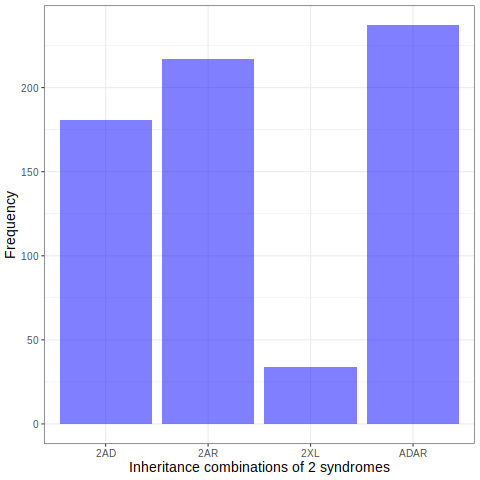

In [22]:
%%R

inh_pl <- ggplot(inh_dat, aes(x=Var1, y=Freq)) + geom_bar(stat = 'identity', fill='blue', alpha=0.5) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + xlab('Inheritance combinations of 2 syndromes') + ylab('Frequency')
inh_pl

## Distribution of variants with 2 annotated diseases

In [17]:
sumvarpheno = pd.read_csv('SumVarPheno.csv', sep='\t')
sumvarpheno.head(2)

,MIMs_per_Gene,GENEINFO,Variants_with_MultiMIMs,N_variants,Percent
0,2,ABCA1,1,20,95.238095
1,2,ABCA1,2,1,4.761905


In [18]:
sumvarpheno.shape

(2195, 5)

In [19]:
sumvarpheno[sumvarpheno['MIMs_per_Gene'] ==2].drop_duplicates(['GENEINFO']).shape

(670, 5)

In [20]:
inh_class = pd.read_csv('Gene2Pheno_Inh_test.csv', sep='\t')
inh_class.head(2) 

,GENEINFO,Ensembl,Inheritance,Inh_class
0,ABCA1,ENSG00000165029,AD,ADAR
1,ABCA1,ENSG00000165029,AR,ADAR


In [21]:
inh_class = inh_class[['GENEINFO', 'Inh_class']].drop_duplicates()

In [22]:
sumgph2 = sumvarpheno[sumvarpheno['MIMs_per_Gene'] ==2]
sumgph2.drop_duplicates(['GENEINFO']).shape

(670, 5)

In [23]:
sumgph2.shape

(1124, 5)

In [24]:
sumgph2 = sumgph2.merge(inh_class, on=['GENEINFO'], how='left')
sumgph2.shape

(1124, 6)

In [25]:
sumgph2.to_csv('sumgph2_for_plot.csv', sep=',', index=False)

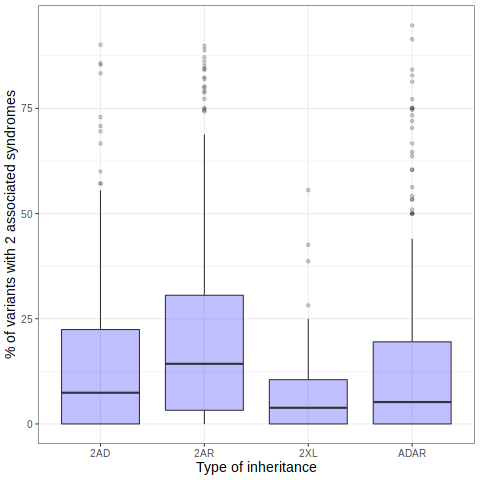

In [26]:
%%R -i sumgph2

ph2_box <- ggplot(na.omit(sumgph2[sumgph2$Variants_with_MultiMIMs == 1, ]), aes(x=Inh_class, y=100-Percent)) + geom_boxplot(fill='blue', alpha=0.25) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + xlab('Type of inheritance') + ylab('% of variants with 2 associated syndromes')
ph2_box

In [28]:
# genes with >=50 pleiotropic variants

sumgph2_50 = sumgph2[(sumgph2.MIMs_per_Gene ==2) & (sumgph2.Variants_with_MultiMIMs == 2) & (sumgph2.Percent >50)]
sumgph2_50.to_csv('G2Ph_pleiotvar_50.csv', sep='\t', index=False)
sumgph2_50.shape

(74, 6)

In [29]:
sumgph2[(sumgph2.MIMs_per_Gene ==2) & (sumgph2.Variants_with_MultiMIMs == 2) ]

,MIMs_per_Gene,GENEINFO,Variants_with_MultiMIMs,N_variants,Percent,Inh_class
1,2,ABCA1,2,1,4.761905,ADAR
3,2,ABCA12,2,4,14.285714,2AR
5,2,ABCB11,2,11,22.000000,2AR
8,2,ACTB,2,5,8.771930,2AD
10,2,ACTG1,2,10,26.315789,2AD
...,...,...,...,...,...,...
1113,2,ZC4H2,2,3,10.000000,2XL
1116,2,ZIC3,2,1,3.846154,2XL
1118,2,ZMPSTE24,2,2,12.500000,2AR
1120,2,ZNF408,2,1,25.000000,ADAR


In [30]:
sumgph2_50_list = sumgph2_50['GENEINFO'].drop_duplicates()

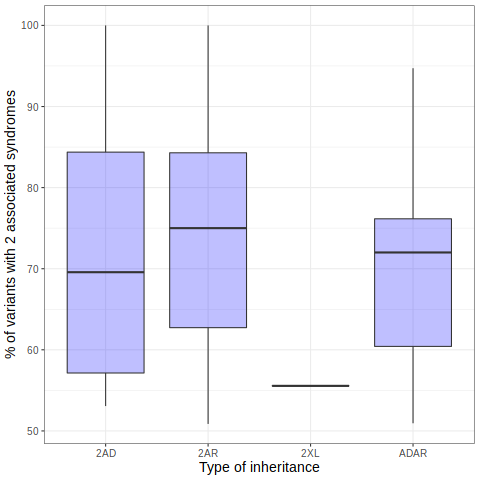

In [37]:
%%R -i sumgph2_50
ph2_50_box <- ggplot(sumgph2_50[sumgph2_50$Variants_with_MultiMIMs == 2, ], aes(x=Inh_class, y=Percent)) + geom_boxplot(fill='blue', alpha=0.25) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + xlab('Type of inheritance') + ylab('% of variants with 2 associated syndromes')
ph2_50_box

## Analysis of variants localization within protein domain boundaries

In [ ]:
df_m = pd.read_csv('clinvar_grch38_plp_hpo_MIMcount.csv', sep='\t')
df_m.head(2)

In [ ]:
# select genes with 2 diseases

df_g2ph = df_m[df_m['MIMs_per_Gene'] == 2]
df_2ph = df_g2ph.groupby(['GENEINFO', 'Ensembl','OMIM']).size().reset_index(name = 'Variants_per_MIM')
df_2ph

In [ ]:
df_g2ph['GENEINFO'].drop_duplicates().shape

In [ ]:
# list of genes with 2 associated phenotypes

df_g2ph_list = df_g2ph['Ensembl'].drop_duplicates()
df_g2ph_list.to_csv('G2MIM_gene_list.csv', sep='\t', index=False)

! sed -i 1d G2MIM_gene_list.csv

In [ ]:
# grep coordinates of G2D from gencode v44 annotation
! grep -wFf G2MIM_gene_list.csv gencode.v44.annotation.gtf > G2MIM_coord.gtf

# select whole genes coordinates
! awk '{if($3 =="gene"){print $0}}' G2MIM_coord.gtf  > G2MIM_gene_coord.gtf

! grep "protein_coding" G2MIM_gene_coord.gtf  > G2MIM_genes.gtf

In [ ]:

## Only curated data
! grep 'Manually reviewed (Swiss-Prot)' ucsc_uniprotdomains.bed > ucsc_uniprotdomains_swiss.bed

In [ ]:
## save only domains (rm Zn-finger regions, topological domains)

! grep  -v -e 'zinc[ ]finger[ ]region' -e 'topological[ ]domain' ucsc_uniprotdomains_swiss.bed > ucsc_uniprotdomains_swiss_domainsonly.bed

In [ ]:
! cat ucsc_uniprotdomains_swiss_domainsonly.bed | cut -f1,2,3 > ucsc_uniprotdomains_swiss_domainsonly_coord.bed

In [ ]:
g2mim_domains_count = pd.read_csv('G2MIM_count_uniprotdomains_swiss_domaisonly_sorted.gtf', sep='\t', 
                            names=['chrom', 'source', 'type', 'start', 'end', 'NA1', 'NA2', 'NA3', 'info',
                                   'intersect'], header=None)
g2mim_domains_count.head(2)

In [ ]:
print(f"N of genes with 2 MIMs, for which domains have been described in UniProt:",
      g2mim_domains_count[g2mim_domains_count['intersect'] > 0].shape[0])

In [ ]:
# select genes with 2 diseases

df_g2ph = df_m[df_m['MIMs_per_Gene'] == 2]
df_2ph = df_g2ph.groupby(['GENEINFO', 'Ensembl','OMIM']).size().reset_index(name = 'Variants_per_MIM')
df_2ph

In [ ]:
dis1 = df_2ph.drop_duplicates(subset = ['Ensembl'], keep = 'first')
dis1

In [ ]:
dis1[['Ensembl', 'OMIM']].to_csv('G2Ph_dis1.csv', sep='\t', index=False)

In [ ]:
# save variants associated with dis1 
df_dis1 = df_g2ph.merge(dis1, how = 'inner')
print(df_dis1.head(2))
print(df_dis1.shape)

In [ ]:
df_dis1[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('G2Pheno_dis1_all_variants.vcf', sep='\t', index=False)

##  Analysis of variants localization and types in G2Ds

In [70]:
cv_mc = pd.read_csv('clinvar_grch38_20230903_MC.txt', sep='\t')
cv_mc.head(2)

,CHROM,ID,MC
0,chr1,950448,SO:0001587|nonsense
1,chr1,916564,SO:0001583|missense_variant


In [ ]:
df_m = pd.read_csv('clinvar_grch38_plp_hpo_MIMcount.csv', sep='\t')
df_m.shape


In [71]:
df_m = df_m.merge(cv_mc, on=["CHROM", "ID"], how='left')
df_m.shape


(155921, 19)

In [72]:
df_m.head(2)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AF_EXAC,CLNREVSTAT,CLNSIG,CLNVC,GENEINFO,OMIM,ORPHA,ncbi_gene_id,Inheritance,Ensembl,MIMs_per_Gene,MC
0,chr1,1013983,1028857,G,A,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1,SO:0001574|splice_acceptor_variant
1,chr1,1014143,183381,C,T,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1,SO:0001587|nonsense


In [73]:
# select genes with 2 diseases

df_g2ph = df_m[df_m['MIMs_per_Gene'] == 2]
df_2ph = df_g2ph.groupby(['GENEINFO', 'Ensembl','OMIM']).size().reset_index(name = 'Variants_per_MIM')
df_2ph

,GENEINFO,Ensembl,OMIM,Variants_per_MIM
0,ABCA1,ENSG00000165029,OMIM:205400,15
1,ABCA1,ENSG00000165029,OMIM:604091,7
2,ABCA12,ENSG00000144452,OMIM:242500,21
3,ABCA12,ENSG00000144452,OMIM:601277,11
4,ABCB11,ENSG00000073734,OMIM:601847,47
...,...,...,...,...
1333,ZNF408,ENSG00000175213,OMIM:616469,2
1334,ZSWIM6,ENSG00000130449,OMIM:603671,1
1335,ZSWIM6,ENSG00000130449,OMIM:617865,1
1336,ZSWIM7,ENSG00000214941,OMIM:619831,2


In [74]:
df_g2ph['GENEINFO'].drop_duplicates().shape

(670,)

In [75]:
# list of genes with 2 associated phenotypes

df_g2ph_list = df_g2ph['Ensembl'].drop_duplicates()
df_g2ph_list.to_csv('G2Ph_ensembl_list.csv', sep='\t', index=False)

! sed -i 1d G2Ph_ensembl_list.csv

### Statistical analysis of  within-gene distribution and type of variants 

#### Collect associated with each disease variants

##### collect all variants 

In [76]:
dis1 = df_2ph.drop_duplicates(subset = ['Ensembl'], keep = 'first')
dis1

,GENEINFO,Ensembl,OMIM,Variants_per_MIM
0,ABCA1,ENSG00000165029,OMIM:205400,15
2,ABCA12,ENSG00000144452,OMIM:242500,21
4,ABCB11,ENSG00000073734,OMIM:601847,47
6,ACO2,ENSG00000100412,OMIM:614559,17
8,ACTB,ENSG00000075624,OMIM:243310,56
...,...,...,...,...
1328,ZIC3,ENSG00000156925,OMIM:306955,25
1330,ZMPSTE24,ENSG00000084073,OMIM:275210,10
1332,ZNF408,ENSG00000175213,OMIM:616468,3
1334,ZSWIM6,ENSG00000130449,OMIM:603671,1


In [77]:
dis1[['Ensembl', 'OMIM']].to_csv('G2Ph_dis1.csv', sep='\t', index=False)

In [78]:
# save variants associated with dis1 

df_dis1 = df_g2ph.merge(dis1, how = 'inner')
print(df_dis1.head(2))
print(df_dis1.shape)

  CHROM      POS      ID REF  ALT  QUAL FILTER  AF_EXAC  \
0  chr1  1338007  931630   T  TGC -10.0   PASS      NaN   
1  chr1  1338053  208049  TG    T -10.0   PASS      NaN   

                            CLNREVSTAT             CLNSIG        CLNVC  \
0  criteria_provided,_single_submitter  Likely_pathogenic  Duplication   
1  criteria_provided,_single_submitter         Pathogenic     Deletion   

  GENEINFO         OMIM                         ORPHA  ncbi_gene_id  \
0     DVL1  OMIM:180700  Orphanet:3107,Orphanet:97360          1855   
1     DVL1  OMIM:180700  Orphanet:3107,Orphanet:97360          1855   

  Inheritance          Ensembl  MIMs_per_Gene                             MC  \
0          AD  ENSG00000107404              2  SO:0001589|frameshift_variant   
1          AD  ENSG00000107404              2  SO:0001589|frameshift_variant   

   Variants_per_MIM  
0                 2  
1                 2  
(19086, 20)


In [79]:
df_dis1[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('G2Pheno_dis1_all_variants.vcf', sep='\t', index=False)

In [80]:
! cat vcf_header.txt G2Pheno_dis1_all_variants.vcf > G2Ph_dis1_all_variants.vcf
! rm G2Pheno_dis1_all_variants.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis1_all_variants.vcf

In [81]:
# extract 2nd disease

dis2 = df_2ph.drop_duplicates(subset = ['Ensembl'], keep = 'last')
dis2

,GENEINFO,Ensembl,OMIM,Variants_per_MIM
1,ABCA1,ENSG00000165029,OMIM:604091,7
3,ABCA12,ENSG00000144452,OMIM:601277,11
5,ABCB11,ENSG00000073734,OMIM:605479,14
7,ACO2,ENSG00000100412,OMIM:616289,6
9,ACTB,ENSG00000075624,OMIM:607371,6
...,...,...,...,...
1329,ZIC3,ENSG00000156925,OMIM:314390,2
1331,ZMPSTE24,ENSG00000084073,OMIM:608612,8
1333,ZNF408,ENSG00000175213,OMIM:616469,2
1335,ZSWIM6,ENSG00000130449,OMIM:617865,1


In [53]:
dis2[['Ensembl', 'OMIM']].to_csv('G2Ph_dis2.csv', sep='\t', index=False)

In [82]:
# save variants associated with 2nd disease

df_dis2 = df_g2ph.merge(dis2, how = 'inner')

print(df_dis2.head(2))
print(df_dis2.shape)

  CHROM      POS      ID REF ALT  QUAL FILTER  AF_EXAC  \
0  chr1  1336516  981468   C   T -10.0   PASS      NaN   
1  chr1  1337992  488046  TC   T -10.0   PASS      NaN   

                            CLNREVSTAT             CLNSIG  \
0       no_assertion_criteria_provided  Likely_pathogenic   
1  criteria_provided,_single_submitter  Likely_pathogenic   

                       CLNVC GENEINFO         OMIM  \
0  single_nucleotide_variant     DVL1  OMIM:616331   
1                   Deletion     DVL1  OMIM:616331   

                          ORPHA  ncbi_gene_id Inheritance          Ensembl  \
0  Orphanet:3107,Orphanet:97360          1855          AD  ENSG00000107404   
1  Orphanet:3107,Orphanet:97360          1855          AD  ENSG00000107404   

   MIMs_per_Gene                                  MC  Variants_per_MIM  
0              2  SO:0001574|splice_acceptor_variant                18  
1              2       SO:0001589|frameshift_variant                18  
(15730, 20)


In [83]:
df_dis2[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('G2Pheno_dis2_all_variants.vcf', sep='\t', index=False)

In [84]:
! cat vcf_header.txt G2Pheno_dis2_all_variants.vcf > G2Ph_dis2_all_variants.vcf
! rm G2Pheno_dis2_all_variants.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis2_all_variants.vcf

##### collect variants without pleiotropic effect

In [85]:
# rm variants that have association with both diseases

snps_dis1 = df_dis1[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_dis2 = df_dis2[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_d1d2 = pd.merge(snps_dis1, snps_dis2, how='outer', indicator=True)

print(snps_dis1.shape)
print(snps_dis2.shape)
print(snps_d1d2.shape)
print(snps_d1d2[snps_d1d2['_merge'] == 'both'].shape)

(19086, 7)
(15730, 7)
(28610, 8)
(6206, 8)


In [86]:
snps_d1d2 = snps_d1d2[snps_d1d2['_merge'] != 'both']
snps_d1d2.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,_merge
0,chr1,1338007,931630,T,TGC,-10.0,PASS,left_only
2,chr1,1516567,1077177,CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...,C,-10.0,PASS,left_only
3,chr1,1517250,592109,GC,G,-10.0,PASS,left_only
4,chr1,1523838,989289,G,T,-10.0,PASS,left_only
5,chr1,1524323,992489,C,CG,-10.0,PASS,left_only


In [87]:
snps_d1_un = snps_d1d2[snps_d1d2['_merge'] == 'left_only']
snps_d1_un.shape

(12880, 8)

In [88]:
snps_d1_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('G2Pheno_dis1_uniq_variants.vcf', sep='\t', index=False)

In [89]:
! cat vcf_header.txt G2Pheno_dis1_uniq_variants.vcf > G2Ph_dis1_uniq.vcf
! rm G2Pheno_dis1_uniq_variants.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis1_uniq.vcf

In [90]:
snps_d2_un = snps_d1d2[snps_d1d2['_merge'] == 'right_only']
snps_d2_un.shape

(9524, 8)

In [91]:

snps_d2_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('G2Pheno_dis2_uniq_variants.vcf', sep='\t', index=False)

In [92]:
! cat vcf_header.txt G2Pheno_dis2_uniq_variants.vcf > G2Ph_dis2_uniq.vcf
! rm G2Pheno_dis2_uniq_variants.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis2_uniq.vcf

##### collect all missense and pLOF variants

In [93]:
df_dis1

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AF_EXAC,CLNREVSTAT,CLNSIG,CLNVC,GENEINFO,OMIM,ORPHA,ncbi_gene_id,Inheritance,Ensembl,MIMs_per_Gene,MC,Variants_per_MIM
0,chr1,1338007,931630,T,TGC,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Likely_pathogenic,Duplication,DVL1,OMIM:180700,"Orphanet:3107,Orphanet:97360",1855,AD,ENSG00000107404,2,SO:0001589|frameshift_variant,2
1,chr1,1338053,208049,TG,T,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,Deletion,DVL1,OMIM:180700,"Orphanet:3107,Orphanet:97360",1855,AD,ENSG00000107404,2,SO:0001589|frameshift_variant,2
2,chr1,1516567,1077177,CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...,C,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,Deletion,ATAD3A,OMIM:617183,Orphanet:496790,55210,ADAR,ENSG00000197785,2,"SO:0001574|splice_acceptor_variant,SO:0001575|...",9
3,chr1,1517250,592109,GC,G,-10.0,PASS,NaN,no_assertion_criteria_provided,Likely_pathogenic,Deletion,ATAD3A,OMIM:617183,Orphanet:496790,55210,ADAR,ENSG00000197785,2,"SO:0001589|frameshift_variant,SO:0001627|intro...",9
4,chr1,1523838,989289,G,T,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Likely_pathogenic,single_nucleotide_variant,ATAD3A,OMIM:617183,Orphanet:496790,55210,ADAR,ENSG00000197785,2,SO:0001574|splice_acceptor_variant,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19081,chrX,154997038,10167,T,G,-10.0,PASS,NaN,"criteria_provided,_multiple_submitters,_no_con...",Pathogenic,single_nucleotide_variant,F8,OMIM:301071,NaN,2157,XL,ENSG00000185010,2,SO:0001583|missense_variant,27
19082,chrX,155022432,10156,C,A,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,F8,OMIM:301071,NaN,2157,XL,ENSG00000185010,2,SO:0001583|missense_variant,27
19083,chrX,155260886,436462,C,A,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,RAB39B,OMIM:300271,Orphanet:777,116442,XL,ENSG00000155961,2,SO:0001587|nonsense,3
19084,chrX,155264073,10542,C,T,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,RAB39B,OMIM:300271,Orphanet:777,116442,XL,ENSG00000155961,2,SO:0001575|splice_donor_variant,3


In [94]:
# subset missense variants dis1

df_dis1_miss = df_dis1[df_dis1['MC'].str.contains('missense', na=False, case=False, regex=False)]

In [98]:
df_dis1_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis1_miss.vcf', sep='\t', index=False)

In [99]:
! cat vcf_header.txt Gene2Pheno_dis1_miss.vcf > G2Ph_dis1_miss.vcf
! rm Gene2Pheno_dis1_miss.vcf 
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis1_miss.vcf

In [100]:
# subset pLOF variants dis2
 
df_dis1_plof = df_dis1[~df_dis1['MC'].str.contains('missense', na=False, case=False, regex=False)]
df_dis1_plof = df_dis1_plof[df_dis1_plof['MC'].str.contains('frameshift') | df_dis1_plof['MC'].str.contains('stop_gained') | df_dis1_plof['MC'].str.contains('splice_donor') | df_dis1_plof['MC'].str.contains('splice_acceptor')]

In [101]:
df_dis1_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis1_plof.vcf', sep='\t', index=False)

In [102]:
! cat vcf_header.txt Gene2Pheno_dis1_plof.vcf > G2Ph_dis1_plof.vcf
! rm Gene2Pheno_dis1_plof.vcf 
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis1_plof.vcf

In [103]:
# subset missense variants dis2

df_dis2_miss = df_dis2[df_dis2['MC'].str.contains('missense', na=False, case=False, regex=False)]

In [104]:
df_dis2_miss.shape

(3907, 20)

In [105]:
df_dis2_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis2_miss.vcf', sep='\t', index=False)

In [106]:
! cat vcf_header.txt Gene2Pheno_dis2_miss.vcf > G2Ph_dis2_miss.vcf
! rm Gene2Pheno_dis2_miss.vcf 
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis2_miss.vcf

In [107]:
# subset pLOF variants dis2

df_dis2_plof = df_dis2[~df_dis2['MC'].str.contains('missense',na=False, case=False, regex=False)]
df_dis2_plof = df_dis2_plof[df_dis2_plof['MC'].str.contains('frameshift', na=False, case=False, regex=False) | df_dis2_plof['MC'].str.contains('stop_gained', na=False, case=False, regex=False) | df_dis2_plof['MC'].str.contains('splice_donor', na=False, case=False, regex=False) | df_dis2_plof['MC'].str.contains('splice_acceptor', na=False, case=False, regex=False)]

In [108]:
df_dis2_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis2_plof.vcf', sep='\t', index=False)

In [109]:
! cat vcf_header.txt Gene2Pheno_dis2_plof.vcf > G2Ph_dis2_plof.vcf
! rm Gene2Pheno_dis2_plof.vcf 
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis2_plof.vcf

##### collect missense and pLOF variants without pleiotropic effect 

In [110]:
# rm missense variants that have association with both diseases

snps_dis1_m = df_dis1_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_dis2_m = df_dis2_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_d1d2_m = pd.merge(snps_dis1_m, snps_dis2_m, how='outer', indicator=True)

print(snps_d1d2_m.shape)
print(snps_d1d2_m[snps_d1d2_m['_merge'] == 'both'].shape)

(7447, 8)
(1362, 8)


In [111]:
snps_d1d2_m = snps_d1d2_m[snps_d1d2_m['_merge'] != 'both']
snps_d1d2_m.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,_merge
0,chr1,1527718,1685550,A,G,-10.0,PASS,left_only
1,chr1,1529299,225696,C,T,-10.0,PASS,left_only
2,chr1,1529300,1679823,G,A,-10.0,PASS,left_only
3,chr1,2406569,1686018,C,G,-10.0,PASS,left_only
6,chr1,5863915,974483,A,G,-10.0,PASS,left_only


In [112]:
snps_d1_m_un = snps_d1d2_m[snps_d1d2_m['_merge'] == 'left_only']
snps_d1_m_un.shape

(3540, 8)

In [113]:
snps_d1_m_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis1_uniq_miss.vcf', sep='\t', index=False)

In [114]:
! cat vcf_header.txt Gene2Pheno_dis1_uniq_miss.vcf > G2Ph_dis1_uniq_miss.vcf
! rm Gene2Pheno_dis1_uniq_miss.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis1_uniq_miss.vcf

In [115]:
snps_d2_m_un = snps_d1d2_m[snps_d1d2_m['_merge'] == 'right_only']
snps_d2_m_un.shape

(2545, 8)

In [116]:

snps_d2_m_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis2_uniq_miss.vcf', sep='\t', index=False)

In [117]:
! cat vcf_header.txt ./VarCount/Gene2Pheno_dis2_uniq_miss.vcf > G2Ph_dis2_uniq_miss.vcf
! rm Gene2Pheno_dis2_uniq_miss.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis2_uniq_miss.vcf

In [118]:
# rm plof variants that have association with both diseases

snps_dis1_p = df_dis1_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_dis2_p = df_dis2_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_d1d2_p = pd.merge(snps_dis1_p, snps_dis2_p, how='outer', indicator=True)

print(snps_d1d2_p.shape)
print(snps_d1d2_p[snps_d1d2_p['_merge'] == 'both'].shape)

(12983, 8)
(2863, 8)


In [119]:
snps_d1d2_p = snps_d1d2_p[snps_d1d2_p['_merge'] != 'both']
snps_d1d2_p.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,_merge
0,chr1,1338007,931630,T,TGC,-10.0,PASS,left_only
2,chr1,1516567,1077177,CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...,C,-10.0,PASS,left_only
3,chr1,1517250,592109,GC,G,-10.0,PASS,left_only
4,chr1,1523838,989289,G,T,-10.0,PASS,left_only
5,chr1,1524323,992489,C,CG,-10.0,PASS,left_only


In [120]:
snps_d1_p_un = snps_d1d2_p[snps_d1d2_p['_merge'] == 'left_only']
snps_d1_p_un.shape

(5773, 8)

In [121]:
snps_d1_p_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis1_uniq_plof.vcf', sep='\t', index=False)

In [122]:
! cat vcf_header.txt Gene2Pheno_dis1_uniq_plof.vcf > G2Ph_dis1_uniq_plof.vcf
! rm Gene2Pheno_dis1_uniq_plof.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis1_uniq_plof.vcf

In [123]:
snps_d2_p_un = snps_d1d2_p[snps_d1d2_p['_merge'] == 'right_only']
snps_d2_p_un.shape

(4347, 8)

In [124]:

snps_d2_p_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('Gene2Pheno_dis2_uniq_plof.vcf', sep='\t', index=False)

In [125]:
! cat vcf_header.txt Gene2Pheno_dis2_uniq_plof.vcf > G2Ph_dis2_uniq_plof.vcf
! rm Gene2Pheno_dis2_uniq_plof.vcf
! sed -i 's/CHROM/#CHROM/g' G2Ph_dis2_uniq_plof.vcf

### Analysis of variants loclization and variant type

#### Data for the analysis:

###### - List of canonical transcripts (source: Ensembl BioMart). PathTo: ./data/canonical_transcripts.txt

###### - Gencode annotation

###### - Selected genes list (Ensembl IDs). PathTo: ./VarCount/G2Ph_ensembl_list.csv

###### - Selected variants annotated to diseases (.vcf)

### Variant localization

In [ ]:
# Split canonical transcript on 5 equal intervals and collect all variants asscoiated with each disease connected to the gene
! bash ./script/g2ph_countvariants_b5all.sh

In [ ]:
# Split canonical transcript on 2 equal intervals and collect all variants asscoiated with each disease connected to the gene
! bash ./script/g2ph_countvariants_b2all.sh

In [ ]:
# Split canonical transcript on 5 equal intervals and collect variants w/o pleiotropic effect for each disease connected to the gene
! bash ./script/g2ph_countvariants_b5u.sh

In [ ]:
# Split canonical transcript on 2 equal intervals and collect variants w/o pleiotropic effect for each disease connected to the gene
! bash ./script/g2ph_countvariants_b2u.sh

### Variant type

In [ ]:
# Collect all missense variants and all pLOF variants 
! bash ./script/g2ph_countvariants_mp_all.sh

In [ ]:
# Collect missense variants and all pLOF variants  w/o pleiotropic effect
! bash ./script/g2ph_countvariants_mp_u.sh

####  Fisher's exact test

In [126]:
%%R

## Q-Q plot ##
# source:   https://slowkow.com/notes/ggplot2-qqplot
gg_qqplot <- function(ps, ci = 0.95) {
  n  <- length(ps)   # number of observations
  df1 <- data.frame(
    observed = -log10(sort(ps)),
    expected = -log10(ppoints(n)),   # prediction based on number of observations
    clower   = -log10(qbeta(p = (1 - ci) / 2, shape1 = 1:n, shape2 = n:1)),
    cupper   = -log10(qbeta(p = (1 + ci) / 2, shape1 = 1:n, shape2 = n:1))
  )
  log10Pe <- expression(paste("Expected -log"[10], plain(P)))
  log10Po <- expression(paste("Observed -log"[10], plain(P)))
  ggplot(df1) +
    geom_ribbon(
      mapping = aes(x = expected, ymin = clower, ymax = cupper),
      alpha = 0.1
    ) +
    geom_point(aes(expected, observed), shape = 1, size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)
}

In [127]:
%%R

# results illustration
plot_fisher <- function(fisher_res){
    
    #   Q-Q plot
    qqplot <- gg_qqplot(as.numeric(fisher_res$p_value)) +
    theme_bw(base_size = 14) +theme(axis.ticks = element_line(size = 0.5),panel.grid = element_blank())
    
    print(qqplot)
    
    #   Barplot
    pval_count <- fisher_res%>% 
      group_by(pvalue_interval) %>%
      summarize(count = n()) %>%
      mutate(prop = (count/sum(count)))
    
    pval_barpl <- ggplot(pval_count, aes(x=factor(pvalue_interval), y=prop)) + geom_bar(stat='identity', fill='blue', alpha=0.4)+ theme_bw() + xlab(NULL) + theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=10)) +  ylab('p-value distribution') #+  scale_y_continuous(labels = percent_format())
    
    #print(pval_barpl)    
}

##### Parse results of splitting CDS on 5 intervals

In [128]:
%%R

fisher_b5 <- function(bins5){
    
    colnames(bins5) <- c('Ensembl', 'd1_1', 'd1_2', 'd1_3', 'd1_4', 'd1_5', 
                     'd2_1','d2_2','d2_3','d2_4','d2_5')
    bins5$Ensembl <- as.character(bins5$Ensembl)
    
    # filter results - rm genes with less than 5 associated variants per disease
    bins5 <- bins5 %>% filter((rowSums(bins5[ , c(2:6)], na.rm=TRUE) >=5) & (rowSums(bins5[ , c(7:11)], na.rm=TRUE) >=5))
    
    fisher_res <- data.frame(matrix(ncol=2, nrow=0))   
    colnames(fisher_res) <- c('Ensembl', 'p_value')
    
    # Fiher's exact test
    for (r in 1:nrow(bins5)){   
        matr <- matrix(c(as.numeric(bins5[r,2:ncol(bins5)])),ncol=(ncol(bins5)-1)/2, byrow=T)
        if (all(matr == 0)){   # exclude genes with no variants
            next
        }
        test <- fisher.test(matr,workspace = 2e8)
        fisher_res[nrow(fisher_res) + 1,] <- c(bins5[r,1], as.numeric(test$p.value))   # add gene_id and p-value
    }
    df <- merge(fisher_res, bins5, by='Ensembl', all.x = TRUE)
    
    # adjust p-value
    df$p_value <- as.numeric(df$p_value)   
    df$p_adj <-p.adjust(df$p_value, method = "fdr")
    df$log_pvalue <- -log10(as.numeric(df$p_value)) 
    df$log_padj <- -log10(as.numeric(df$p_adj)) 
    
 
    df <- df %>%
     mutate(pvalue_interval = case_when(
     p_value < 0.1 ~ "0-0.1", 
     p_value >= 0.1 & p_value < 0.2 ~ "0.1-0.2",
     p_value >= 0.2 & p_value < 0.3 ~ "0.2-0.3",
     p_value >= 0.3 & p_value < 0.4 ~ "0.3-0.4",
     p_value >= 0.4 & p_value < 0.5 ~ "0.4-0.5",
     p_value >= 0.5 & p_value < 0.6 ~ "0.5-0.6",
     p_value >= 0.6 & p_value < 0.7 ~ "0.6-0.7",
     p_value >= 0.7 & p_value < 0.8 ~ "0.7-0.8",
     p_value >= 0.8 & p_value < 0.9 ~ "0.8-0.9",
     p_value >= 0.9 ~ "0.9-1"))
    
    df$pvalue_interval <- as.factor(df$pvalue_interval)
    
    df <- df[ ,c(1,16,2,14,13,15,3,4,5,6,7,8,9,10,11,12)]
   
}

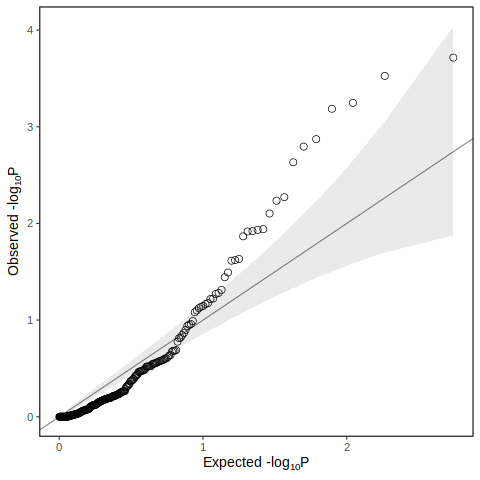

In [129]:
%%R

# Load data: all genes associated with 2 diseases, all variants
bins5_all <- read.csv('G2Ph_bins5_all.csv', sep=',', header=T)

# Fisher's exact test
bins5_all_FT <- fisher_b5(bins5_all)

# Plot results
plot_fisher(bins5_all_FT)

# Save results
write.csv(bins5_all_FT,"G2Ph_bins5_all_FT.csv", row.names = FALSE, quote = F)



#### Genes associated with 2 diseases split by inheritance pattern. CDSs are split on 5 intervals. All variants

In [130]:
%%R

# Load inheritance data
g2ph_inh <- read.csv('Gene2Pheno_Inh.csv', sep='\t', header=T)

##### Same inheritance

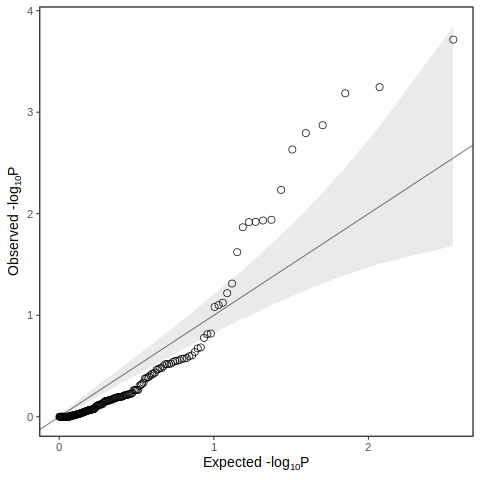

In [131]:
%%R

# Add inheritance data to variant location analyisis
bins5_all_inh <- merge(bins5_all, g2ph_inh, by='Ensembl', all.x=TRUE)

# Subset 
bins5_all_SInh <- bins5_all_inh[bins5_all_inh$Inh_class =='2AD'| bins5_all_inh$Inh_class =='2AR',c(1:11)]

# Fisher's exact test
bins5_all_SInh_FT <- fisher_b5(bins5_all_SInh)

# Plot results
plot_fisher(bins5_all_SInh_FT)

##### Different inheritance

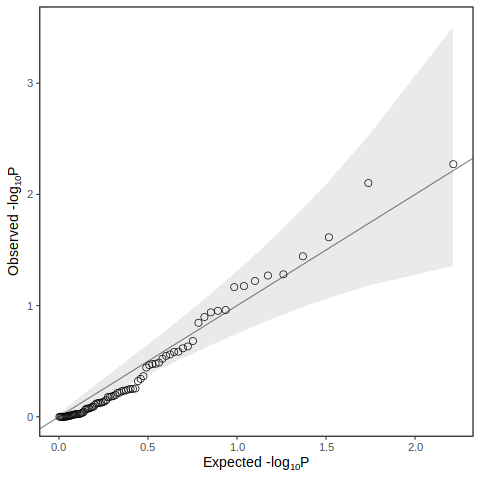

In [132]:
%%R
# Add inheritance data to variant location analyisis
bins5_all_inh <- merge(bins5_all, g2ph_inh, by='Ensembl', all.x=TRUE)

# Subset 
bins5_all_DInh <- bins5_all_inh[bins5_all_inh$Inh_class =='ADAR',c(1:11)]

# Fisher's exact test
bins5_all_DInh_FT <- fisher_b5(bins5_all_DInh)

# Plot results
plot_fisher(bins5_all_DInh_FT)

#### Genes associated with 2 diseases.  CDSs are split on 5 intervals. No pleiotropic variants

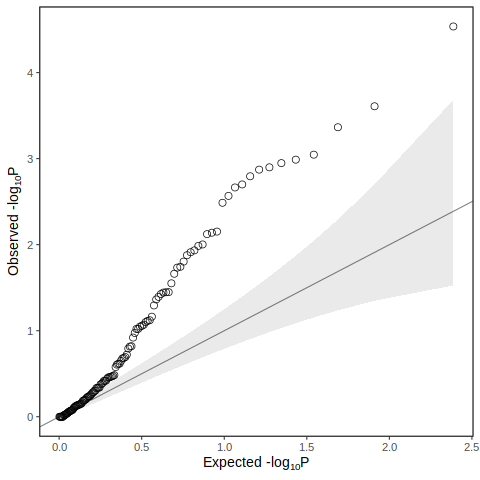

In [134]:
%%R

# Load data
bins5_un <- read.csv('G2Ph_bins5_uniq.csv', sep=',', header=T)

# Fisher's exact test
bins5_uniq_FT <- fisher_b5(bins5_un)

# Plot results
plot_fisher(bins5_uniq_FT)

# Save results

write.csv(bins5_uniq_FT,"G2Ph_bins5_uniq_FT.csv", row.names = FALSE, quote = F)

### Analyse results for 2 intervals

In [137]:
%%R

fisher_b2 <- function(bins2){
    
    colnames(bins2) <- c('Ensembl', 'd1_1', 'd1_2', 'd2_1', 'd2_2')
    bins2$Ensembl <- as.character(bins2$Ensembl)
    
    # filter results - rm genes with less than 5 associated variants per disease
    bins2 <- bins2 %>% filter((rowSums(bins2[ , c(2,3)], na.rm=TRUE) >=5) & (rowSums(bins2[ , c(4,5)], na.rm=TRUE) >=5))
    
    
    fisher_res <- data.frame(matrix(ncol=2, nrow=0))   
    colnames(fisher_res) <- c('Ensembl', 'p_value')
    
    # Fisher's exact test
    for (r in 1:nrow(bins2)){   
        matr <- matrix(c(as.numeric(bins2[r,2:ncol(bins2)])),ncol=(ncol(bins2)-1)/2, byrow=T)
        if (all(matr == 0)){   # exclude genes with no variants
            next
        }
        test <- fisher.test(matr,workspace = 2e8)
        fisher_res[nrow(fisher_res) + 1,] <- c(bins2[r,1], as.numeric(test$p.value))   # add gene_id and p-value
    }
    df <- merge(fisher_res, bins2, by='Ensembl', all.x = TRUE)
    
    # adjust p-value
    df$p_value <- as.numeric(df$p_value)   
    df$p_adj <-p.adjust(df$p_value, method = "fdr")
    df$log_pvalue <- -log10(as.numeric(df$p_value)) 
    df$log_padj <- -log10(as.numeric(df$p_adj)) 
    
 
    df <- df %>%
     mutate(pvalue_interval = case_when(
     p_value < 0.1 ~ "0-0.1", 
     p_value >= 0.1 & p_value < 0.2 ~ "0.1-0.2",
     p_value >= 0.2 & p_value < 0.3 ~ "0.2-0.3",
     p_value >= 0.3 & p_value < 0.4 ~ "0.3-0.4",
     p_value >= 0.4 & p_value < 0.5 ~ "0.4-0.5",
     p_value >= 0.5 & p_value < 0.6 ~ "0.5-0.6",
     p_value >= 0.6 & p_value < 0.7 ~ "0.6-0.7",
     p_value >= 0.7 & p_value < 0.8 ~ "0.7-0.8",
     p_value >= 0.8 & p_value < 0.9 ~ "0.8-0.9",
     p_value >= 0.9 ~ "0.9-1"))
    
    df$pvalue_interval <- as.factor(df$pvalue_interval)
    
    df <- df[ ,c(1,10,2,7,8,9,3,4,5,6)]
   
}

#### Genes associated with 2 diseases. CDSs are split on 2 intervals. All variants

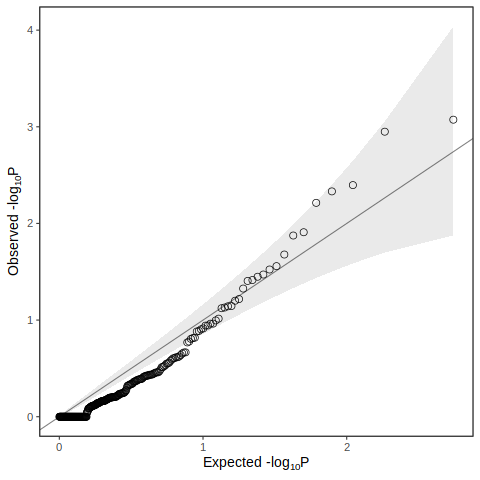

In [138]:
%%R

# Load data
bins2_all <- read.csv('G2Ph_bins2_all.csv', sep=',', header=T)

# Fisher's exact test
bins2_all_FT <- fisher_b2(bins2_all)

# Plot results
plot_fisher(bins2_all_FT)

# Save results

write.csv(bins2_all_FT,"G2Ph_bins2_all_FT.csv", row.names = FALSE, quote = F)

#### Genes associated with 2 diseases. CDSs are split on 2 intervals. No  pleiotropic variants

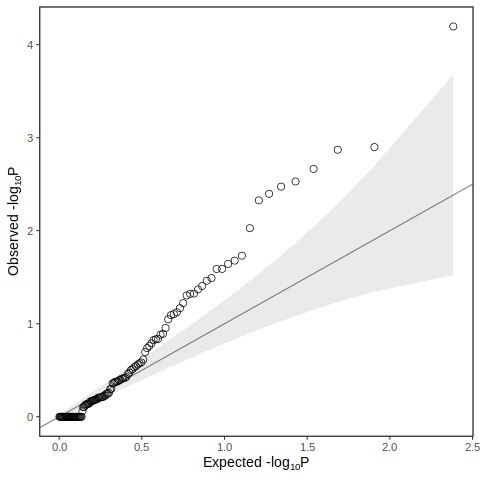

In [139]:
%%R

# Load data
bins2_uniq <- read.csv('G2Ph_bins2_uniq.csv', sep=',', header=T)

# Fisher's exact test
bins2_uniq_FT <- fisher_b2(bins2_uniq)

# Plot results
plot_fisher(bins2_uniq_FT)

# Save results

write.csv(bins2_uniq_FT,"bins2_uniq_FT.csv", row.names = FALSE, quote = F)

### Analyse missense and pLOF data

In [153]:
%%R

fisher_mp <- function(miss, plof){
    
    # merge 
    mp <- merge(miss, plof, by='Ensembl')
    mp <- mp[, c(1,2,4,3,5)]
    
    colnames(mp) <- c('Ensembl', 'd1_missense', 'd1_plof', 'd2_missense', 'd2_plof')
    mp$Ensembl <- as.character(mp$Ensembl)
    
    # filter results - rm genes with less than 5 associated variants per disease
    mp <- mp %>% filter((rowSums(mp[ , c(2,3)], na.rm=TRUE) >=5) & (rowSums(mp[ , c(4,5)], na.rm=TRUE) >=5))
    
    fisher_res <- data.frame(matrix(ncol=2, nrow=0))   
    colnames(fisher_res) <- c('Ensembl', 'p_value')
    
    # Fiher's exact test
    for (r in 1:nrow(mp)){   
        matr <- matrix(c(as.numeric(mp[r,2:ncol(mp)])),ncol=(ncol(mp)-1)/2, byrow=T)
        if (all(matr == 0)){   # exclude genes with no variants
            next
        }
        test <- fisher.test(matr,workspace = 2e8)
        fisher_res[nrow(fisher_res) + 1,] <- c(mp[r,1], as.numeric(test$p.value))   # add gene_id and p-value
    }
    df <- merge(fisher_res, mp, by='Ensembl', all.x = TRUE)
    
    # adjust p-value
    df$p_value <- as.numeric(df$p_value)   
    df$p_adj <-p.adjust(df$p_value, method = "fdr")
    df$log_pvalue <- -log10(as.numeric(df$p_value)) 
    df$log_padj <- -log10(as.numeric(df$p_adj)) 
    
 
    df <- df %>%
     mutate(pvalue_interval = case_when(
     p_value < 0.1 ~ "0-0.1", 
     p_value >= 0.1 & p_value < 0.2 ~ "0.1-0.2",
     p_value >= 0.2 & p_value < 0.3 ~ "0.2-0.3",
     p_value >= 0.3 & p_value < 0.4 ~ "0.3-0.4",
     p_value >= 0.4 & p_value < 0.5 ~ "0.4-0.5",
     p_value >= 0.5 & p_value < 0.6 ~ "0.5-0.6",
     p_value >= 0.6 & p_value < 0.7 ~ "0.6-0.7",
     p_value >= 0.7 & p_value < 0.8 ~ "0.7-0.8",
     p_value >= 0.8 & p_value < 0.9 ~ "0.8-0.9",
     p_value >= 0.9 ~ "0.9-1"))
    
    df$pvalue_interval <- as.factor(df$pvalue_interval)
    
    df <- df[ ,c(1,10,2,7,8,9,3,4,5,6)]
   
}

#### Genes associated with 2 diseases. All variants

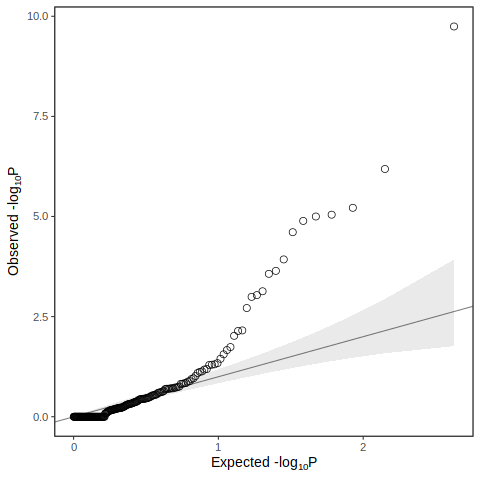

In [154]:
%%R

# Load data

## missense 
miss_all <- read.csv('G2Ph_miss.csv', sep=',', header=T)

## pLOF
plof_all <- read.csv('G2Ph_plof.csv', sep=',', header=T)

# Fisher's exact test
mp_all_FT <- fisher_mp(miss_all, plof_all)

# Plot results
plot_fisher(mp_all_FT)

# Save results
write.csv(mp_all_FT,"G2Ph_missplof_FT", row.names = FALSE, quote = F)

#### Genes associated with 2 diseases. No pleiotropic variants

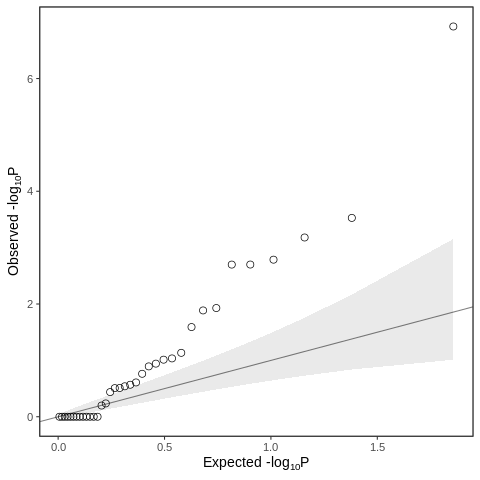

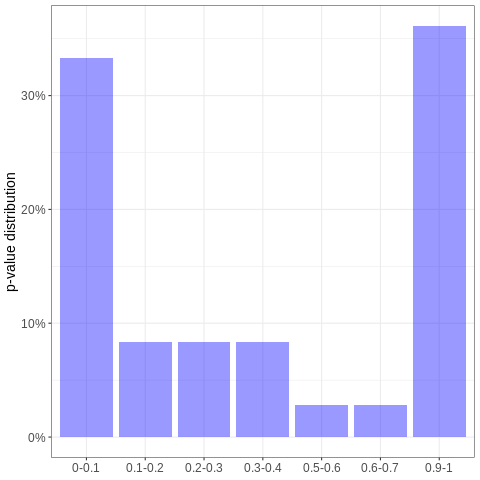

In [269]:
%%R

## missense 
miss_un <- read.csv('G2Ph_uniq_miss.csv', sep=',', header=T)

## pLOF
plof_un <- read.csv('G2Ph_uniq_plof.csv', sep=',', header=T)

# Fisher's exact test
mp_uniq_FT <- fisher_mp(miss_un, plof_un)

# Plot results
plot_fisher(mp_uniq_FT)

# Save results
write.csv(mp_uniq_FT,"G2Ph_missplof_uniq_FT.csv", row.names = FALSE, quote = F)

##  Full dataframes

In [145]:
%%R

create_full_df <- function(fisher_res){
    
    # Inheritance info
    inh <- read.csv('Gene2Pheno_Inh.csv', sep='\t', header=TRUE)
    
    
    dis1 <- read.csv('G2Ph_dis1.csv',sep='\t', header=TRUE)
    dis2 <- read.csv('G2Ph_dis2.csv',sep='\t', header=TRUE)
    
    df_p1 <- list(fisher_res,inh, dis1, dis2)      
    
    df_p1 <- df_p1 %>% purrr::reduce(left_join, by='Ensembl')
    
   
    # pLI,loeuf
    gnmd <- read.csv('gnomad.v2.1.1.pli_loeuf.txt', sep='\t',header=TRUE)
    
    df_p2 <- merge(df_p1, gnmd, by.x='GENEINFO', by.y='gene', all.x=TRUE)  
}

In [146]:
%%R

bins5_all_info <- create_full_df(bins5_all_FT)

write.csv(bins5_all_info, 'G2Ph_bins5_all_info.csv', row.names = FALSE, quote = F)

In [147]:
%%R

bins2_all_info <- create_full_df(bins2_all_FT)
write.csv(bins2_all_info, 'G2Ph_bins2_all_info.csv', row.names = FALSE, quote = F)

In [148]:
%%R

bins5_uniq_info <- create_full_df(bins5_uniq_FT)
write.csv(bins5_uniq_info, 'G2Ph_bins5_uniq_info.csv', row.names = FALSE, quote = F)

In [149]:
%%R

bins2_uniq_info <- create_full_df(bins2_uniq_FT)
write.csv(bins2_uniq_info, 'G2Ph_bins2_uniq_info.csv', row.names = FALSE, quote = F)

In [155]:
%%R

mp_all_info <- create_full_df(mp_all_FT)
write.csv(mp_all_info, 'G2Ph_missplof_all_info.csv', row.names = FALSE, quote = F)

In [302]:
%%R

mp_uniq_info <- create_full_df(mp_uniq_FT)
write.csv(mp_uniq_info, 'G2Ph_missplof_uniq_info.csv', row.names = FALSE, quote = F)

##  Plots

In [156]:
%%R

plots <- function(dat){
    
    dat <- dat %>%
     mutate(pvalue_class = case_when(
         p_value < 0.1 ~ "0-0.1", 
         p_value >= 0.1  ~ "0.1-1"
     ))
    
    pval_inh <- dat[ ,c('pvalue_class','Inh_class')]
    pval_inh <- pval_inh%>%
       group_by(pvalue_class,Inh_class) %>%
       summarize(count = n()) %>%
       mutate(prop = (count/sum(count)))
    
    
    # variant location - inheritance pattern
    pval_inh_bar <- ggplot(pval_inh, aes(y=prop, x=pvalue_class, label=count, fill=factor(Inh_class))) +
    geom_bar(position="stack", stat="identity")+ theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) +  xlab('pvalue interval') +  ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + geom_text(size = 4, position = position_stack(vjust = 0.5))
    
    pval_inh_bar <- pval_inh_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom")
    pval_inh_bar <- pval_inh_bar + theme(aspect.ratio = 1/2)  + coord_flip() + scale_fill_brewer(palette = "RdBu")
    
    print(pval_inh_bar)
    
    
    # variant location - pLI
    
    dat <- dat %>% 
       mutate(pli_class = case_when(
       pLI <= 0.1 ~ 'pLOF tolerant (pLI <=0.1)',
       pLI >= 0.9 ~ 'pLOF intolerant (pLI >=0.9)',
       TRUE ~ 'intermediate tolerance'))
    
    pval_pli <- dat[ ,c('pvalue_class', 'pli_class')]
    
    pval_pli <- pval_pli%>%
       group_by(pvalue_class, pli_class) %>%
       summarize(count = n()) %>%
       mutate(prop = (count/sum(count)))
    
    pval_pli_bar <- ggplot(pval_pli, aes(y=prop, x=pvalue_class, label=count, 
                                    fill=factor(pli_class, levels=c("pLOF intolerant (pLI >=0.9)",
                                                           "intermediate tolerance",
                                                           "pLOF tolerant (pLI <=0.1)")))) +
    geom_bar(position="stack", stat="identity")+ theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) + xlab('pvalue interval') +  ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + geom_text(size = 6, position = position_stack(vjust = 0.5))
    
    pval_pli_bar <- pval_pli_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom") + scale_fill_brewer(palette = "RdBu")
    pval_pli_bar <- pval_pli_bar + theme(aspect.ratio = 1/2)  + coord_flip()
    print(pval_pli_bar) 
}

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.


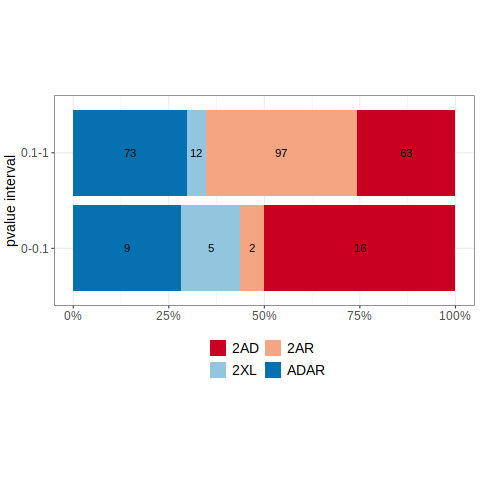

In [152]:
%%R

bins5_all_info <- read.csv('G2Ph_bins5_all_info.csv', sep=',', header=TRUE)
plots(bins5_all_info)


In [6]:
%%R

bins2_all_info <- read.csv('G2Ph_bins2_all_info.csv', sep=',', header=TRUE)
plots(bins2_all_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.


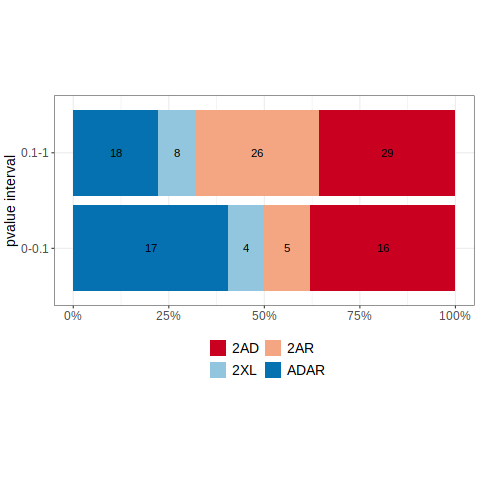

In [59]:
%%R

bins5_uniq_info <- read.csv('G2Ph_bins5_uniq_info.csv', sep=',', header=TRUE)
plots(bins5_uniq_info)

In [5]:
%%R

bins2_uniq_info <- read.csv('G2Ph_bins2_uniq_info.csv', sep=',', header=TRUE)
plots(bins2_uniq_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.


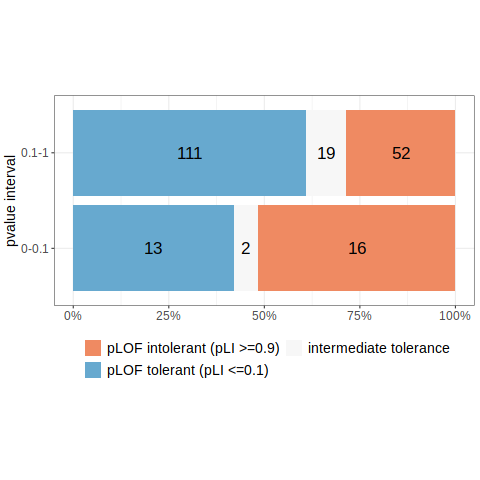

In [157]:
%%R

missplof_all_info <- read.csv('G2Ph_missplof_all_info.csv', sep=',', header=TRUE)
plots(missplof_all_info)

In [3]:
%%R

missplof_uniq_info <- read.csv('G2Ph_missplof_uniq_info.csv', sep=',', header=TRUE)
plots(missplof_uniq_info)